# Introduction

# Set Up

In [219]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
import cdapsutil
import ndex2

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [12]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/rerun_")

In [220]:
sys.path.append(cwd)
from analysis_functions import *

In [64]:
# load data, contains original subgraphs
data = pd.read_csv(DATADIR + "outputs/rat_human_BMI_all_NPS.tsv", sep = "\t", index_col=0)
data.head()

,NPS_r,NPS_h,NPS_hr
gene,,,
A1BG,0.125314,-0.488576,-0.061226
A1CF,2.540447,2.186042,5.553524
A2M,0.651845,-0.581848,-0.379275
A2ML1,-1.315517,-1.108608,1.458393
A3GALT2,-0.546107,-0.243477,0.132964


In [37]:
# load seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [65]:
data = data.assign(rat_seed=[1 if gene in seed_bin_rat_BMI else 0 for gene in data.index])
data = data.assign(human_seed=[1 if gene in seed_bin_human_BMI else 0 for gene in data.index])

# Examine the distributions of the species NPS

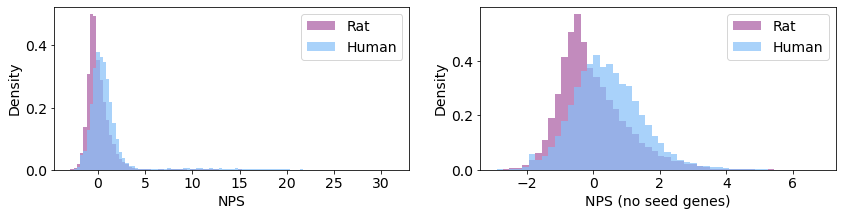

In [43]:
matplotlib.rcParams.update({'font.size': 14})
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
_, bins, _ = ax1.hist(data.NPS_r, bins=100, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax1.hist(data.NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax1.set_ylabel("Density")
ax1.set_xlabel("NPS")
ax1.legend()

_, bins, _ = ax2.hist(data[data.rat_seed==0].NPS_r, bins=50, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax2.hist(data[data.human_seed==0].NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax2.set_ylabel("Density")
ax2.set_xlabel("NPS (no seed genes)")
ax2.legend()


In [6]:
data.loc[:, ("NPS_r", "NPS_h")].describe()

,z_rat,z_human
count,18820.000000,18820.000000
mean,0.166117,1.064944
std,1.819963,3.034380
min,-2.908312,-3.953688
25%,-0.699091,-0.227384
50%,-0.220273,0.450951
75%,0.566990,1.240185
max,31.286290,34.273300


In [7]:
data[data.rat_seed==0].NPS_r.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    18525.000000
mean        -0.013611
std          1.030633
min         -2.908312
50%         -0.237388
75%          0.518693
80%          0.729556
85%          1.005072
90%          1.354651
95%          1.952714
max          6.798332
Name: z_rat, dtype: float64

In [8]:
data[data.human_seed==0].NPS_h.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    16862.000000
mean         0.425921
std          1.047217
min         -3.953688
50%          0.348532
75%          1.069361
80%          1.240472
85%          1.464345
90%          1.742707
95%          2.219446
max          6.620334
Name: z_human, dtype: float64

# Defining species specific Networks

## Set thresholds

In [66]:
# set thresholds:
conserved = {"rat":1, "human":1, "combo":3}
rat_only = {"rat":1, "human":0.5, "combo":-2}
human_only = {"rat":0, "human":1.5, "combo":-4}

Original SubGraph designations come from thresholds:  
`conserved = {"rat":1, "human":1, "combo":3}`  
`rat_only = {"rat":1, "human":0.5, "combo":-1.5}`  
`human_only = {"rat":0.5, "human":1, "combo":-1.5}`

**Combo scores are used as follows:**  

  
Conserved: $z_{rat}\bullet z_{human} > combo$  
  
Rat Only: $z_{rat}\bullet (z_{human} - 1) < combo$  
  
Human Only: $(z_{rat}-1)\bullet z_{human} < combo$

## Identify subgraphs

In [91]:
def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                 ("subgraph")] = "Rat-Only"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                 ("subgraph")] = "Human-Only"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

In [92]:
data = assign_sub_graph(data, th_dict = conserved, name="conserved")
data = assign_sub_graph(data, th_dict = rat_only, name="rat")
data = assign_sub_graph(data, th_dict = human_only, name="human")

In [93]:
data.value_counts("subgraph", dropna=False)

subgraph
PCNet         16550
Human-Only      925
Rat-Only        688
Conserved       657
dtype: int64

In [ ]:
# export the data
data.to_csv(DATADIR + "outputs/rat_only_human_only_networks.tsv", sep="\t")

## Visualize the species specific networks

In [86]:
import seaborn as sns

In [199]:
def plot_species_nps(data, subgraph, th_dict=None, ax=None):
    x_points = [(i+0.0001)/10 for i in range(-50,250)]
    if subgraph == "conserved":
        cmap = {"Conserved": "#F5793A", **{k:"grey" for k in ["Rat-Only", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/25]
        ax.plot([x for x in x_points if x > th_dict["combo"]/25], combo_line, color="#f5793a")
    elif subgraph == "rat":
        cmap = {"Rat-Only": "#a95aa1", **{k:"grey" for k in ["Conserved", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/(x-1) for x in x_points if x < 1 + th_dict["combo"]/25]
        ax.plot([x for x in x_points if x < 1 + th_dict["combo"]/25], combo_line, color="#f5793a")
    elif subgraph == "human":
        cmap = {"Human-Only": "#85c0f9", **{k:"grey" for k in ["Rat-Only", "PCNet", "Conserved"]}}
        combo_line = [1 + th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/-6]
        ax.plot([x for x in x_points if x > th_dict["combo"]/-6], combo_line, color="#f5793a")
    else:
        cmap = {"Conserved": "#F5793A","Rat-Only": "#a95aa1", "Human-Only": "#85c0f9", "PCNet":"grey" }
    
    sns.scatterplot(data=data, x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, s=5, ax=ax, markers=True, alpha=0.8
                )
    if th_dict is not None:
        ax.hlines(y=th_dict["rat"], xmin=-5, xmax=25, color="#a95aa1", alpha=1, zorder=4)
        ax.vlines(x=th_dict["human"], ymin=-5, ymax=25, color="#85c0f9", alpha=1, zorder=3)
    
    ax.spines['left'].set(position=('data', 0.0), zorder=2)
    ax.spines['bottom'].set(position=('data', 0.0), zorder=2)
    ax.spines['top'].set_position(('data', 0.0))
    ax.spines['right'].set_position(('data', 0.0))

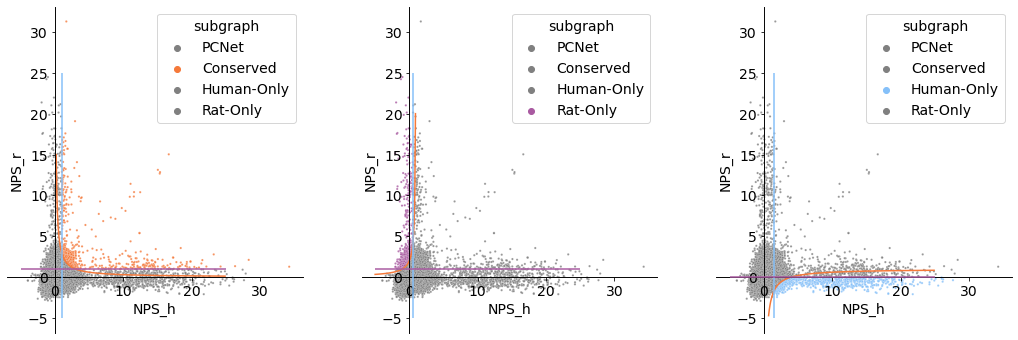

In [200]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_species_nps(data, "conserved", conserved, ax1)
plot_species_nps(data, "rat", rat_only, ax2)
plot_species_nps(data, "human", human_only, ax3)

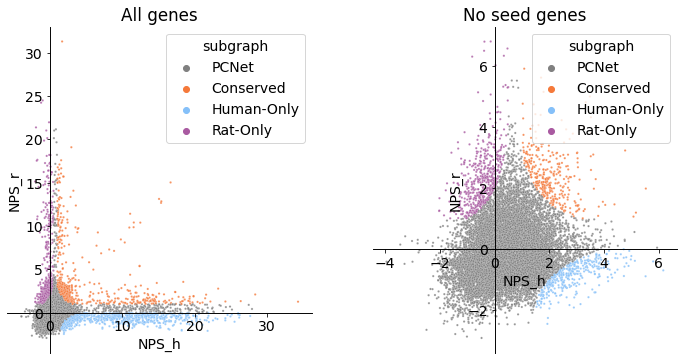

In [216]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_species_nps(data, "all", ax=ax1)
plot_species_nps(data[data.rat_seed+data.human_seed==0], "all", ax=ax2)
_ = ax2.set_title("No seed genes")
_ = ax1.set_title("All genes")

## Assess seed gene fractions

In [227]:
data = data.assign(overlapping_seeds=1*(data.rat_seed + data.human_seed==2))
data.head()

,NPS_r,NPS_h,NPS_hr,rat_seed,human_seed,subgraph,overlapping_seeds
gene,,,,,,,
A1BG,0.125314,-0.488576,-0.061226,0,0,PCNet,0
A1CF,2.540447,2.186042,5.553524,0,0,Conserved,0
A2M,0.651845,-0.581848,-0.379275,0,0,PCNet,0
A2ML1,-1.315517,-1.108608,1.458393,0,0,PCNet,0
A3GALT2,-0.546107,-0.243477,0.132964,0,1,PCNet,0


In [266]:
subgraph_stats = data.groupby("subgraph").sum().loc[:, ("rat_seed", "human_seed", "overlapping_seeds")]

In [273]:
subgraph_stats = subgraph_stats.join(data.groupby("subgraph").count().loc[:, "NPS_r"])
subgraph_stats = subgraph_stats.rename(columns={"NPS_r":"count"})
subgraph_stats["Network"] = subgraph_stats["count"].values - subgraph_stats.loc[:,("rat_seed", "human_seed", "overlapping_seeds")].sum(axis=1).values
subgraph_stats.drop(columns=["count"], inplace=True)
subgraph_stats = subgraph_stats.loc[:,( "human_seed", "overlapping_seeds","rat_seed", "Network") ]

(0.0, 1300.0)

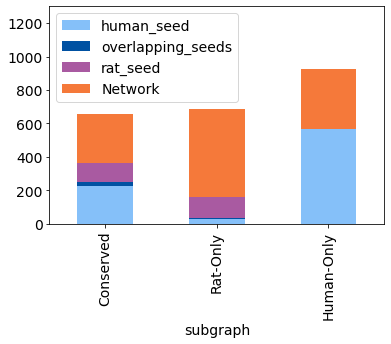

In [280]:
subgraph_stats.loc[["Conserved", "Rat-Only", "Human-Only"]].plot(kind="bar", stacked=True, color=["#85c0f9", "#0051a2",
                                                                                                 "#a95aa1", "#F5793a"])
plt.ylim((0, 1300))

# Hierarchical Community Detection of Species Specific Networks

In [32]:
pc_nodes, G = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [33]:
data_all.head()

,z_rat,z_human,z_both,SubGraph,rat_seed,human_seed,hue,NewSubGraph
UBE2Q1,-1.046722,-0.059048,0.061807,None,0,0,grey,None
RNF14,0.246439,-0.413490,-0.101900,None,0,0,grey,None
UBE2Q2,0.128908,-0.090295,-0.011640,None,0,1,grey,None
TMCO1,1.451465,-0.319948,-0.464393,rat-only,0,0,grey,None
UBAC1,-0.464716,1.268305,-0.589401,human-only,0,0,grey,None


### Set Up/Functions

In [ ]:
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

def create_hierarchy(G_cx, max_resolution=10):
    cd = cdapsutil.CommunityDetection()
    G_hier = cd.run_community_detection(G_cx, algorithm='hidefv1.1beta',arguments={'--maxres':str(max_resolution)})
    print('Hierarchy name: ' + str(G_hier.get_name()))
    print('# nodes: ' + str(len(G_hier.get_nodes())))
    print('# edges: ' + str(len(G_hier.get_edges())))
    hier_nx = G_hier.to_networkx(mode='default')
    nodes = hier_nx.nodes()
    # print out interactome num nodes and edges for diagnostic purposes
    print('number of nodes:')
    print(len(hier_nx.nodes()))
    print('\nnumber of edges:')
    print(len(hier_nx.edges()))
    # add node attributes to dataframe for easier access
    hier_df = pd.DataFrame.from_dict(dict(hier_nx.nodes(data=True)), orient='index')
    # relabel nodes in G_ASD
    # G_ASD=nx.relabel_nodes(G_ASD,dict(hier_df['CD_CommunityName']))
    hier_df['system_ID']=hier_df.index.tolist()
    # some columns are not the right type
    hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
    hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
    hier_df.set_index("name", inplace=True, drop=True)
    hier_df.index.name=None
    return G_hier, hier_df


def annotate_hierarchy(hier_df):
    system_name_list = []
    all_results = []
    for p in hier_df.index.tolist():
        try:
            focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
        except AttributeError:
            focal_genes = hier_df['CD_MemberList'].loc[p]
        print(p, ":", len(focal_genes))
        if len(focal_genes)>2:
            gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['GO:BP'],no_evidences=False))
            if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
                gp_temp = gp_temp[(gp_temp['term_size']<1000)]
                gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
                gp_temp = gp_temp[gp_temp['p_value']<1E-3] # set a stringent pvalue threshold
            
            # try sorting by precision + recall
            #gp_temp['prec_plus_recall']=gp_temp['precision']+gp_temp['recall']
                gp_temp = gp_temp.sort_values('p_value',ascending=True)
            
                gp_temp.index=gp_temp['name']
                for t in gp_temp.index.tolist():
                    if t.lower().find('dopamin')>-1:
                        print(gp_temp.loc[t][['p_value','intersections']])
                    
                gp_cols_keep = ['description','name','p_value','precision','recall',
                            'query_size','effective_domain_size','intersection_size','native','source',
                           'term_size','intersections', 'community']

            
                if len(gp_temp)>1:
                    system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
                #gp_temp[gp_cols_keep].to_csv('../tables/rat_human_BMI_hierarchy_GO/'+str(p)+'.csv',sep=',',
                      #    index=False)
                    gp_temp = gp_temp.assign(community=p)
                    all_results.append(gp_temp[gp_cols_keep])
                else:
                    system_name_list.append(p)
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
    return pd.concat(all_results)
        

In [ ]:
import sys
sys.path.append("..")

from analysis_functions import *
from plotting_functions import *
from updated_netcoloc_functions import *

In [ ]:
pc_nodes, G = load_pcnet()

In [ ]:
updated_pc_nodes = mg.querymany(pc_nodes, as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')

In [ ]:
updated_pc_nodes = updated_pc_nodes.sort_values(by="_score", ascending=False)
updated_pc_nodes = updated_pc_nodes.drop_duplicates(subset=["symbol"])

In [ ]:
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt',
                                         map_using="mgi")

In [ ]:
mgi_df = change_symbols(mgi_df, updated_pc_nodes)

In [ ]:
MPO2 = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)

In [ ]:
mp_graph = get_mp_graph()
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0003012", "MP:0002873"]][1:]

In [ ]:
def get_seed_gene_fractions(hier_df, seed_human, seed_rat):
    try:
        hier_df["CD_MemberList"] = hier_df.CD_MemberList.apply(lambda x: x.split(" "))
    except AttributeError:
        pass
    comm_genes = hier_df.explode("CD_MemberList")
    comm_genes["h_seed"] = [1 if x in seed_human else 0 for x in comm_genes.CD_MemberList]
    comm_genes["r_seed"] = [1 if x in seed_rat else 0 for x in comm_genes.CD_MemberList]
    comm_genes["overlap"] = comm_genes.apply(lambda x: x.h_seed * x.r_seed, axis=1)
    a = comm_genes.groupby(level=0).overlap.sum()
    b = comm_genes[comm_genes.overlap != 1].groupby(level=0).h_seed.sum()
    c = comm_genes[comm_genes.overlap != 1].groupby(level=0).r_seed.sum()
    d = comm_genes.groupby(level=0).CD_MemberList.count()
    counts = pd.concat([a,b,c,d], axis=1)
    counts["network"] = counts.apply(lambda x: x.CD_MemberList - x.overlap - x.h_seed - x.r_seed, axis=1)
    fracs = counts.div(counts.CD_MemberList, axis=0)
    return fracs
    
def load_human_seed_genes(filepath, interactome_nodes, trait=''):
    """
    :param filepath:
    :param interactome_nodes:
    :param trait:
    """
    all_scores = pd.read_csv(filepath, sep="\t", index_col='gene_symbol')
    # subset to genes in the interactome
    all_scores = all_scores.loc[list(np.intersect1d(all_scores.index.tolist(), interactome_nodes))]
    # Calculate bonferroni corrected pvalue (alpha=0.05)
    bonf_p = .05/len(all_scores)
    # Get significant genes
    seeds = all_scores[all_scores['pvalue'] < bonf_p].index.tolist()
    print("Number of",trait,"seeds:", len(seeds))
    return seeds

In [ ]:
SEEDDIR= '~/Data/rat/data/final/'# location of input datasets


In [68]:
# add fractions seed genes
seed_bin_rat_BMI=pd.read_csv(SEEDDIR+'ratBMI_seed_'+'relaxed'+'.txt',sep='\t')['0'].tolist()
seed_bin_human_BMI = load_human_seed_genes(SEEDDIR+'GIANT_BMI_pascal.sum.genescores.txt', 
                                           pc_nodes, 'BMI')

Number of BMI seeds: 1958


In [ ]:
# add key annotations for BMI
mps = [num_to_mp(x) for x in [5378, 2089,5451,4196, 3956,10866, 1697]]

### Rat

In [100]:
G_rat = G.subgraph(nodes=data_all.loc[data_all.NewSubGraph=="rat-only"].index)
G_rat_cx = ndex2.create_nice_cx_from_networkx(G_rat)
G_rat_cx.set_name("RatOnly")

In [101]:
G_rat, hier_rat_df = create_hierarchy(G_rat_cx)

Hierarchy name: hidefv1.1beta_(none)_RatOnly
# nodes: 67
# edges: 69
number of nodes:
67

number of edges:
69


In [102]:
rat_anno = annotate_hierarchy(hier_rat_df)

C688 : 654
C689 : 236
C690 : 206
C691 : 56
C695 : 26
C699 : 19
C700 : 18
C702 : 17
C703 : 16
C704 : 15
C712 : 11
C715 : 11
C716 : 11
C718 : 10
C722 : 9
C724 : 8
C727 : 8
C729 : 8
C730 : 8
C731 : 7
C734 : 7
C735 : 6
C750 : 4
C736 : 6
C737 : 6
C741 : 5
C742 : 5
C746 : 4
C747 : 4
C748 : 4
C719 : 10
C720 : 10
C751 : 4
C726 : 8
C694 : 33
C728 : 8
C732 : 7
C705 : 13
C708 : 12
C709 : 12
C710 : 12
C743 : 5
C744 : 5
C692 : 41
C696 : 26
C701 : 17
C753 : 4
C738 : 6
C693 : 33
C697 : 21
C706 : 12
C698 : 20
C752 : 4
C714 : 11
C711 : 12
C721 : 9
C717 : 11
C754 : 4
C733 : 7
C707 : 12
C713 : 11
C723 : 8
C739 : 6
C749 : 4
C725 : 8
C745 : 5
C740 : 6


In [103]:
rat_anno.to_csv("~/Data/Transfer/rat/rat_only_all_annotations.tsv", sep="\t")

In [23]:
rat_phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)
for community in tqdm(hier_rat_df.index):
    x = community_term_enrichment(community, hier_rat_df, MPO2, mgi_df, term_counts, gene_mapping, G_int=G)
    x = x.assign(name=community)
    rat_phenotypes.append(x)

100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


In [24]:
rat_results = pd.concat(rat_phenotypes)

In [26]:
rat_results.to_csv(DATADIR+"rat_only_enrichment_results.tsv", sep="\t")

In [106]:
rat_fracs = get_seed_gene_fractions(hier_rat_df, seed_bin_human_BMI, seed_bin_rat_BMI)
hier_rat_df= hier_rat_df.join(rat_fracs.loc[:, ("h_seed", "r_seed", "overlap", "network")])

In [107]:

rat_gbs = rat_results.loc[mps]
rat_gbs = rat_gbs[rat_gbs["OR_p"] < 0.05]
rat_gbs = rat_gbs.pivot(index="name", columns=["description"], values=["OR"])

In [108]:
hier_rat_df = hier_rat_df.join(rat_gbs.droplevel(level=0, axis=1))

In [109]:
# add initial name from gprofiler
rat_anno_filt = rat_anno[rat_anno["term_size"] < 1000]
rat_anno_filt["percent"] = rat_anno_filt["intersection_size"] / rat_anno_filt["query_size"]
rat_annot_filt = rat_anno_filt[rat_anno_filt["percent"] > 0.25].sort_values(by="p_value")

In [110]:
rat_annotations = rat_annot_filt.drop_duplicates(subset="community").loc[:, ("name", "p_value", "intersection_size", "community")]
rat_annotations.set_index("community", inplace=True, drop=True)
rat_annotations.index.name=None
rat_annotations.columns = ["go_annotation", "GO_p", "GO_intersect"]

In [111]:
hier_rat_df= hier_rat_df.join(rat_annotations)

In [112]:

hier_rat_df.to_csv(DATADIR+"hier_rat_only_df.tsv", sep="\t")

### Human

In [113]:
G_human = G.subgraph(nodes=data_all.loc[data_all.NewSubGraph=="human-only"].index)
G_human_cx = ndex2.create_nice_cx_from_networkx(G_human)
G_human_cx.set_name("HumanOnly")

In [114]:
G_human, hier_human_df = create_hierarchy(G_human_cx)

Hierarchy name: hidefv1.1beta_(none)_HumanOnly
# nodes: 54
# edges: 54
number of nodes:
54

number of edges:
54


In [115]:
hier_human_df

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,system_ID
C925,GXYLT2 DDX19B CDC37 HOXC12 FREM3 ULK1 ARPC1A C...,914,False,9.836,,,0,0.0,0.0,110,C925,0
C928,BOLL C3orf20 LRRC66 ITLN1 JUND FIBCD1 PRSS55 I...,49,False,5.615,,,0,0.0,0.0,8,C928,1
C960,TGFB1 SLC35F4 SLC35G5 SLC35G2 SLC35F5,5,False,2.322,,,0,0.0,0.0,97,C960,2
C964,SENP3 NCKAP5L ZNF438 CCDC122 RABEP1,5,False,2.322,,,0,0.0,0.0,6,C964,3
C969,SEC16B PRDX2 MSRA ERP44,4,False,2.0,,,0,0.0,0.0,12,C969,4
C938,KCNRG AP5B1 KCTD13 KIAA1841 AGBL5 AGBL4 AGBL3 ...,11,False,3.459,,,0,0.0,0.0,13,C938,5
C970,ATP2A3 ATP13A1 ATP8B3 ATP13A5,4,False,2.0,,,0,0.0,0.0,21,C970,6
C941,BCL3 ANKRD54 ANKRD29 ANKRD39 NFKBID ANKDD1B AN...,9,False,3.17,,,0,0.0,0.0,28,C941,7
C942,BHLHE22 MAMLD1 CCND1 NCOR1 HES5 HEYL HEY2 MAML...,9,False,3.17,,,0,0.0,0.0,19,C942,8
C958,PEPD AFG1L C12orf60 CCDC171 LDHAL6B MDH2,6,False,2.585,,,0,0.0,0.0,7,C958,9


In [116]:
human_anno = annotate_hierarchy(hier_human_df)

C925 : 914
C928 : 49
C960 : 5
C964 : 5
C969 : 4
C938 : 11
C970 : 4
C941 : 9
C942 : 9
C958 : 6
C949 : 7
C952 : 7
C959 : 6
C926 : 475
C927 : 362
C929 : 27
C931 : 21
C937 : 13
C939 : 10
C940 : 10
C945 : 9
C946 : 8
C947 : 8
C948 : 7
C951 : 7
C953 : 7
C954 : 7
C955 : 7
C956 : 7
C957 : 6
C961 : 5
C962 : 5
C965 : 5
C966 : 4
C967 : 4
C971 : 4
C972 : 4
C973 : 4
C974 : 4
C975 : 4
C976 : 4
C978 : 4
C930 : 25
C932 : 19
C933 : 17
C935 : 15
C936 : 14
C943 : 9
C944 : 9
C977 : 4
C950 : 7
C968 : 4
C934 : 16
C963 : 5


In [117]:
human_anno.to_csv("~/Data/Transfer/rat/human_only_all_annotations2.tsv", sep="\t")

In [29]:
human_phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)
for community in tqdm(hier_human_df.index):
    x = community_term_enrichment(community, hier_human_df, MPO2, mgi_df, term_counts, gene_mapping, G_int=G)
    x = x.assign(name=community)
    human_phenotypes.append(x)

100%|██████████| 54/54 [00:22<00:00,  2.44it/s]


In [30]:
human_results = pd.concat(human_phenotypes)

In [31]:
human_results.to_csv(DATADIR+"human_only_enrichment_results.tsv", sep="\t")

In [120]:
human_fracs = get_seed_gene_fractions(hier_human_df, seed_bin_human_BMI, seed_bin_rat_BMI)
hier_human_df= hier_human_df.join(human_fracs.loc[:, ("h_seed", "r_seed", "overlap", "network")])


In [121]:
human_gbs = human_results.loc[mps]
human_gbs = human_gbs[human_gbs["OR_p"] < 0.05]
human_gbs = human_gbs.pivot(index="name", columns=["description"], values=["OR"])

In [122]:

hier_human_df = hier_human_df.join(human_gbs.droplevel(level=0, axis=1))

In [123]:
human_anno_filt = human_anno[human_anno["term_size"] < 1000]
human_anno_filt["percent"] = human_anno_filt["intersection_size"] / human_anno_filt["query_size"]
human_annot_filt = human_anno_filt[human_anno_filt["percent"] > 0.10].sort_values(by="p_value")

In [124]:
human_annotations = human_annot_filt.drop_duplicates(subset="community").loc[:, ("name", "p_value", "intersection_size", "community")]
human_annotations.set_index("community", inplace=True, drop=True)
human_annotations.index.name=None
human_annotations.columns = ["go_annotation", "GO_p", "GO_intersect"]

In [125]:
hier_human_df= hier_human_df.join(human_annotations)

In [126]:

hier_human_df.to_csv(DATADIR+"hier_human_only_df2.tsv", sep="\t")

## Export results to cytoscape files

### Rat

In [127]:
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_rat_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


In [131]:
G_rat.set_name("RatOnly-systemsMap")
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_rat.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


In [128]:
print(network_uuid)

https://www.ndexbio.org/v2/network/e00a960c-abab-11ec-b3be-0ac135e8bacf


### Human

In [129]:
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_human_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


In [132]:
G_human.set_name("HumanOnly-systemsMap")
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_human.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


In [130]:
print(network_uuid)

https://www.ndexbio.org/v2/network/e6c0e0df-abab-11ec-b3be-0ac135e8bacf


## Explore enrichments

### Rat

In [34]:
rat_comms = ["C688","C690","C692","C695","C697","C704","C706","C712","C717",'C721','C722','C730','C739','C740','C744']

In [22]:
hier_rat_df = pd.read_csv(DATADIR+"hier_rat_only_df.tsv", sep="\t", index_col=0)
hier_rat_df["CD_MemberList"] = hier_rat_df.CD_MemberList.apply(lambda x: x[2:-2].split("', '"))

In [38]:
rat_annotations = pd.DataFrame({"represents":hier_rat_df.index, "name":hier_rat_df.index})

In [32]:
rat_results = pd.read_csv(DATADIR+"rat_only_enrichment_results.tsv", sep="\t", index_col=0)

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name
MP:0000001,461,12416,1.240954,0.013246,1.046099,1.472103,0.005413,False,mammalian phenotype,654,C688
MP:0005376,246,6165,1.247545,0.007171,1.061786,1.465803,0.003367,False,homeostasis/metabolism phenotype,654,C688
MP:0005378,226,5952,1.147186,0.101154,0.973497,1.351864,0.046977,False,growth/size/body region phenotype,654,C688
MP:0010768,225,6248,1.057398,0.505453,0.897223,1.246167,0.238719,False,mortality/aging,654,C688
MP:0001764,222,5499,1.255167,0.006939,1.064257,1.480322,0.003311,False,abnormal homeostasis,654,C688


name_x,C688,C690,C692,C695,C697,C704,C706,C712,C717,C721,C722,C730,C739,C740,C744
description,,,,,,,,,,,,,,,
growth/size/body region phenotype,NaN,1.827574,7.723123,0.281633,9.211794,3.24634,4.328398,NaN,21.654325,7.574601,7.574601,NaN,25.969728,10.818060,NaN
postnatal growth/weight/body size,NaN,1.683776,4.192741,NaN,4.383665,NaN,3.980932,3.316565,6.969404,NaN,NaN,NaN,NaN,NaN,NaN
body composition,NaN,1.860052,4.997667,NaN,6.351856,NaN,4.116453,NaN,10.094458,4.609346,NaN,NaN,NaN,5.760331,NaN
prenatal growth/weight/body size,NaN,NaN,2.460507,NaN,NaN,NaN,8.537977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body size,NaN,1.725109,4.079438,NaN,3.534184,NaN,4.709775,3.923622,5.652095,NaN,NaN,NaN,NaN,NaN,7.060055
prenatal body size,NaN,NaN,NaN,NaN,NaN,NaN,8.143382,NaN,NaN,NaN,NaN,5.419572,NaN,NaN,NaN
embryo size,NaN,NaN,NaN,NaN,NaN,NaN,6.533406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


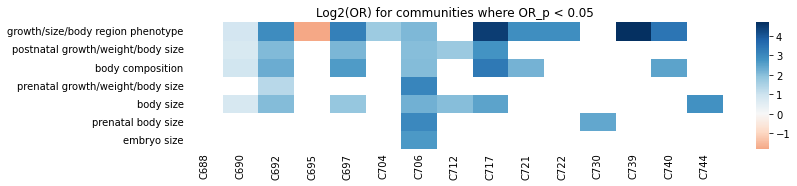

In [42]:

plot_community_heatmap(rat_results, mps, rat_comms, rat_annotations, MPO2, filter_th=0.05, stat="OR", filter_stat="OR_p",
                          ylabel_groups=None, color_range=None, vert=None, horz=12)

### Human

In [27]:
hier_human_df = pd.read_csv(DATADIR+"hier_human_only_df2.tsv", sep="\t", index_col=0)
hier_human_df["CD_MemberList"] = hier_human_df.CD_MemberList.apply(lambda x: x[2:-2].split("', '"))

In [33]:
human_results = pd.read_csv(DATADIR+"human_only_enrichment_results.tsv", sep="\t", index_col=0)
human_results.head()

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name
MP:0000001,652,12416,1.299275,4.669190e-04,1.122050,1.504492,1.662458e-04,False,mammalian phenotype,914,C925
MP:0010768,372,6248,1.405166,8.804435e-07,1.226980,1.609228,4.803153e-07,True,mortality/aging,914,C925
MP:0010769,351,5844,1.408854,9.442906e-07,1.228446,1.615756,5.426258e-07,True,abnormal survival,914,C925
MP:0005378,342,5952,1.310482,1.179688e-04,1.141968,1.503863,5.996213e-05,False,growth/size/body region phenotype,914,C925
MP:0010770,329,5265,1.477763,3.646079e-08,1.286009,1.698110,2.560850e-08,True,preweaning lethality,914,C925


In [109]:
hier_human_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,...,abnormal body composition,abnormal body size,abnormal embryo size,abnormal postnatal growth/weight/body size,abnormal prenatal body size,abnormal prenatal growth/weight/body size,growth/size/body region phenotype,go_annotation,GO_p,GO_intersect
C925,"[GXYLT2, DDX19B, CDC37, HOXC12, FREM3, ULK1, A...",914,False,9.836,NaN,NaN,0,0.0,0.0,110,...,NaN,1.213640,1.700507,1.252411,1.672613,1.663216,1.310482,NaN,NaN,NaN
C928,"[BOLL, C3orf20, LRRC66, ITLN1, JUND, FIBCD1, P...",49,False,5.615,NaN,NaN,0,0.0,0.0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421068,protein side chain deglutamylation,3.321941e-08,4.0
C960,"[TGFB1, SLC35F4, SLC35G5, SLC35G2, SLC35F5]",5,False,2.322,NaN,NaN,0,0.0,0.0,97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C964,"[SENP3, NCKAP5L, ZNF438, CCDC122, RABEP1]",5,False,2.322,NaN,NaN,0,0.0,0.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C969,"[SEC16B, PRDX2, MSRA, ERP44]",4,False,2.000,NaN,NaN,0,0.0,0.0,12,...,17.283148,14.121019,NaN,11.937285,NaN,NaN,NaN,NaN,NaN,NaN


## COMBO HIERARCHY

In [49]:
data_all.NewSubGraph.value_counts()

None          16550
human-only      925
rat-only        688
Name: NewSubGraph, dtype: int64

In [53]:
data_all[data_all.NewSubGraph != "None"].shape

(2270, 8)

In [54]:
G_combo = G.subgraph(nodes=data_all.loc[data_all.NewSubGraph!="None"].index)
G_combo_cx = ndex2.create_nice_cx_from_networkx(G_combo)
G_combo_cx.set_name("comboGraph")

In [57]:
G_combo, hier_combo_df = create_hierarchy(G_combo_cx, max_resolution=20)

Hierarchy name: hidefv1.1beta_(none)_comboGraph
# nodes: 130
# edges: 131
number of nodes:
130

number of edges:
131


In [58]:
combo_anno = annotate_hierarchy(hier_combo_df)

C2270 : 2252
C2308 : 12
C2318 : 10
C2321 : 10
C2326 : 9
C2328 : 9
C2335 : 8
C2336 : 8
C2341 : 7
C2342 : 7
C2347 : 7
C2350 : 7
C2352 : 6
C2356 : 6
C2359 : 6
C2364 : 5
C2370 : 5
C2377 : 4
C2379 : 4
C2380 : 4
C2381 : 4
C2388 : 4
C2271 : 1055
C2272 : 952
C2280 : 36
C2292 : 17
C2303 : 13
C2310 : 11
C2314 : 10
C2320 : 10
C2322 : 10
C2333 : 8
C2338 : 7
C2339 : 7
C2349 : 7
C2360 : 6
C2362 : 5
C2363 : 5
C2365 : 5
C2367 : 5
C2368 : 5
C2374 : 5
C2375 : 4
C2383 : 4
C2391 : 4
C2392 : 4
C2397 : 4
C2398 : 4
C2274 : 402
C2282 : 34
C2286 : 28
C2295 : 16
C2296 : 16
C2302 : 13
C2309 : 11
C2317 : 10
C2319 : 10
C2324 : 9
C2327 : 9
C2329 : 9
C2343 : 7
C2354 : 6
C2366 : 5
C2369 : 5
C2372 : 5
C2373 : 5
C2382 : 4
C2395 : 4
C2399 : 4
C2273 : 435
p_value                                                   0.000014
intersections    [SYT9, SYT4, SYT12, SYT6, SYT7, SYT17, SYT2, S...
Name: regulation of dopamine secretion, dtype: object
p_value                                                   0.000014
intersections  

In [59]:
combo_anno.to_csv("~/Data/Transfer/rat/combo_all_annotations.tsv", sep="\t")

In [60]:
combo_phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)
for community in tqdm(hier_combo_df.index):
    x = community_term_enrichment(community, hier_combo_df, MPO2, mgi_df, term_counts, gene_mapping, G_int=G)
    x = x.assign(name=community)
    combo_phenotypes.append(x)

 11%|█         | 14/130 [00:08<00:18,  6.26it/s]

0/6 in MPO.genes/seeds


 15%|█▌        | 20/130 [00:09<00:13,  8.29it/s]

0/4 in MPO.genes/seeds


 50%|█████     | 65/130 [00:29<00:20,  3.13it/s]

0/4 in MPO.genes/seeds


100%|██████████| 130/130 [00:49<00:00,  2.61it/s]


In [61]:
combo_results = pd.concat(combo_phenotypes)

In [62]:
combo_results.to_csv(DATADIR+"combo_only_enrichment_results.tsv", sep="\t")

In [72]:
combo_fracs = get_seed_gene_fractions(hier_combo_df, seed_bin_human_BMI, seed_bin_rat_BMI)
hier_combo_df= hier_combo_df.join(combo_fracs.loc[:, ("h_seed", "r_seed", "overlap", "network")])

In [73]:

combo_gbs = combo_results.loc[mps]
combo_gbs = combo_gbs[combo_gbs["OR_p"] < 0.05]
combo_gbs = combo_gbs.pivot(index="name", columns=["description"], values=["OR"])

In [74]:
hier_combo_df = hier_combo_df.join(combo_gbs.droplevel(level=0, axis=1))

In [77]:
# add initial name from gprofiler
combo_anno_filt = combo_anno[combo_anno["term_size"] < 1000]
combo_anno_filt["percent"] = combo_anno_filt["intersection_size"] / combo_anno_filt["query_size"]
combo_annot_filt = combo_anno_filt[combo_anno_filt["percent"] > 0.25].sort_values(by="p_value")

In [82]:
combo_annotations = combo_annot_filt.drop_duplicates(subset="community").loc[:, ("name", "p_value", "intersection_size", "community")]
combo_annotations.set_index("community", inplace=True, drop=True)
combo_annotations.index.name=None
combo_annotations.columns = ["go_annotation", "GO_p", "GO_intersect"]

In [83]:
combo_annotations.head()

,go_annotation,GO_p,GO_intersect
C2278,glycosaminoglycan biosynthetic process,5.234215e-48,25
C2280,phospholipid metabolic process,1.819841e-42,29
C2281,sensory perception of chemical stimulus,3.220614e-30,23
C2285,exocytosis,1.996820e-25,19
C2275,sensory perception,1.044596e-21,31


In [84]:
hier_combo_df= hier_combo_df.join(combo_annotations)

In [85]:

hier_combo_df.to_csv(DATADIR+"hier_combo_df.tsv", sep="\t")

In [86]:
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_combo_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


In [87]:
G_combo.set_name("combo-systemsMap")
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_combo.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: snwright
NDEx password: ········
Generating CX


## Gene Lists

In [118]:
def write_gene_lists(hier_df,out_dir, prefix="", community=None):
    if community is not None:
        genes = hier_df.loc[community, "CD_MemberList"]
        if type(genes) == str:
            genes = genes.split(" ")
        with open(out_dir+prefix+community+".txt", 'w') as file:
            file.writelines( "%s\n" % item for item in genes)
    else:
        for comm in tqdm(hier_df.index):
            genes = hier_df.loc[comm, "CD_MemberList"]
            if type(genes) == str:
                genes = genes.split(" ")
            with open(out_dir+prefix+comm+".txt", 'w') as file:
                file.writelines( "%s\n" % item for item in genes)

In [119]:
OUTDIR = "/cellar/users/snwright/Data/Transfer/rat/Community_Gene_Lists/"
write_gene_lists(hier_human_df, OUTDIR, prefix="H_",community=None)

100%|██████████| 54/54 [00:00<00:00, 182.97it/s]


In [120]:
write_gene_lists(hier_rat_df, OUTDIR, prefix="R_",community=None)

100%|██████████| 67/67 [00:00<00:00, 369.24it/s]


In [128]:
h_genes

,genes,source
0,GXYLT2,network
1,DDX19B,network
2,CDC37,network
3,HOXC12,network
4,FREM3,network
...,...,...
909,DDX20,network
910,PARD3B,network
911,ITGAX,network
912,ANKRD42,network


In [129]:
def get_source(gene):
    if gene in seed_bin_human_BMI:
        if gene in seed_bin_rat_BMI:
            return "both"
        else:
            return "human"
    elif gene in seed_bin_rat_BMI:
        return "rat"
    else:
        return "network"

In [72]:
h_genes = pd.DataFrame({"name":hier_human_df.loc["C925", "CD_MemberList"]})
h_genes["source"] = h_genes["name"].apply(get_source)
h_genes.to_csv(OUTDIR + "../human_only_gene_sources.tsv", sep="\t", index=False)

NameError: name 'hier_human_df' is not defined

In [136]:
h_genes.source.value_counts()

human      561
network    353
Name: source, dtype: int64

In [141]:
r_genes = pd.DataFrame({"name":hier_rat_df.loc["C688", "CD_MemberList"]})
r_genes["source"] = r_genes["name"].apply(get_source)
r_genes.to_csv(OUTDIR + "../rat_only_gene_sources.tsv", sep="\t", index=False)

In [139]:
r_genes.source.value_counts()

network    506
rat        122
human       21
both         5
Name: source, dtype: int64

## Query MyGeneInfo

In [193]:
OUTDIR = "/cellar/users/snwright/Data/Transfer/rat/Community_Gene_Lists/"
h_genes= pd.read_csv(OUTDIR + "../human_only_gene_sources.tsv", sep="\t", index_col=None)
r_genes= pd.read_csv(OUTDIR + "../rat_only_gene_sources.tsv", sep="\t", index_col=None)

In [194]:
import mygene
mg = mygene.MyGeneInfo()

In [195]:
updated_h_genes = mg.querymany(h_genes["name"], as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')
updated_h_genes = updated_h_genes.sort_values(by="_score", ascending=False)
updated_h_genes = updated_h_genes[~updated_h_genes.index.duplicated(keep='first')]

querying 1-914...done.
Finished.
38 input query terms found dup hits:
	[('MMP25', 3), ('CKB', 2), ('GALNT16', 2), ('PDXDC2P', 2), ('ELOA3B', 2), ('LTBP3', 2), ('LIG3', 2),
6 input query terms found no hit:
	['AC108488.2', 'LOC613037', 'AC004080.3', 'AC010422.6', 'AC006538.2', 'AC004997.1']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [196]:
h_orthologs = mg.querymany(updated_h_genes.loc[~updated_h_genes["symbol"].isna(), ("symbol")].values, 
                           as_dataframe=True, species='rat', scopes='symbol', fields='symbol')
h_orthologs = h_orthologs.sort_values(by="_score", ascending=False)
h_orthologs = h_orthologs[~h_orthologs.index.duplicated(keep="first")]
h_orthologs["new_query"] = h_orthologs.index
h_orthologs = h_orthologs.loc[:, ("new_query", "symbol")]
h_orthologs.columns = ["new_query", "rat_symbol"]

querying 1-908...done.
Finished.
7 input query terms found dup hits:
	[('KNCN', 2), ('SOWAHC', 2), ('ASXL3', 2), ('PCDH7', 2), ('PDRG1', 2), ('MANF', 2), ('FAM114A2', 2)]
106 input query terms found no hit:
	['PRR20D', 'PPAN-P2RY11', 'LINC01600', 'KRTAP9-9', 'C5orf64', 'NT5C1B-RDH14', 'RPS10-NUDT3', 'TBC1D3
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [197]:
h_data = updated_h_genes.merge(h_orthologs.loc[:, ("new_query","rat_symbol")], left_on="symbol", right_on="new_query")

In [198]:
h_orthologs = mg.querymany(updated_h_genes.loc[~updated_h_genes["symbol"].isna(), ("symbol")].values, 
                           as_dataframe=True, species='mouse', scopes='symbol', fields='symbol')
h_orthologs = h_orthologs.sort_values(by="_score", ascending=False)
h_orthologs = h_orthologs[~h_orthologs.index.duplicated(keep="first")]
h_orthologs["new_query"] = h_orthologs.index
h_orthologs = h_orthologs.loc[:, ("new_query", "symbol")]
h_orthologs.columns = ["new_query", "mouse_symbol"]

querying 1-908...done.
Finished.
11 input query terms found dup hits:
	[('LCN15', 2), ('ALDOA', 2), ('HOXB13', 2), ('PHF11', 2), ('CDK3', 2), ('TRIM8', 2), ('LAMTOR2', 2),
106 input query terms found no hit:
	['PRR20D', 'PPAN-P2RY11', 'LINC01600', 'KRTAP9-9', 'C5orf64', 'NT5C1B-RDH14', 'RPS10-NUDT3', 'TBC1D3
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [199]:
h_data = h_data.merge(h_orthologs.loc[:, ("new_query","mouse_symbol")], left_on="symbol", right_on="new_query")
h_data = h_data.loc[:, ("symbol", "mouse_symbol", "rat_symbol")]

In [200]:
updated_h_genes["query"] = updated_h_genes.index
h_final = updated_h_genes.merge(h_data, on="symbol").loc[:, ("symbol", "mouse_symbol", "rat_symbol", "query")].sort_values(by="rat_symbol")

In [209]:
h_final = h_final.set_index("query")

In [211]:
h_final.describe()

,symbol,mouse_symbol,rat_symbol
count,908,802,802
unique,908,802,802
top,AAAS,Aaas,Aaas
freq,1,1,1


In [214]:
(908-802)/908

0.11674008810572688

In [217]:
h_final.sort_index().to_csv(OUTDIR+"../human_only_orthologs.tsv", sep="\t")

### Rat

In [201]:
updated_r_genes = mg.querymany(r_genes["name"], as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')
updated_r_genes = updated_r_genes.sort_values(by="_score", ascending=False)
updated_r_genes = updated_r_genes[~updated_r_genes.index.duplicated(keep='first')]

querying 1-654...done.
Finished.
16 input query terms found dup hits:
	[('MDP1', 2), ('PAK5', 3), ('EIF3FP3', 2), ('HNRNPA3P1', 2), ('F3', 2), ('VDAC1P5', 2), ('LPCAT4', 2
2 input query terms found no hit:
	['AC067968.1', 'AC135068.1']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [202]:
r_orthologs = mg.querymany(updated_r_genes.loc[~updated_r_genes["symbol"].isna(), ("symbol")].values, 
                           as_dataframe=True, species='rat', scopes='symbol', fields='symbol')
r_orthologs = r_orthologs.sort_values(by="_score", ascending=False)
r_orthologs = r_orthologs[~r_orthologs.index.duplicated(keep="first")]
r_orthologs["new_query"] = r_orthologs.index
r_orthologs = r_orthologs.loc[:, ("new_query", "symbol")]
r_orthologs.columns = ["new_query", "rat_symbol"]

querying 1-652...done.
Finished.
1 input query terms found dup hits:
	[('ARHGAP40', 2)]
64 input query terms found no hit:
	['C3CER1', 'CTAGE8', 'CDY2A', 'POTEE', 'CGB2', 'JMJD7-PLA2G4B', 'ZNF587', 'C6orf226', 'C17orf97', 'V
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [203]:
r_data = updated_r_genes.merge(r_orthologs.loc[:, ("new_query","rat_symbol")], left_on="symbol", right_on="new_query")

In [204]:
r_orthologs = mg.querymany(updated_r_genes.loc[~updated_r_genes["symbol"].isna(), ("symbol")].values, 
                           as_dataframe=True, species='mouse', scopes='symbol', fields='symbol')
r_orthologs = r_orthologs.sort_values(by="_score", ascending=False)
r_orthologs = r_orthologs[~r_orthologs.index.duplicated(keep="first")]
r_orthologs["new_query"] = r_orthologs.index
r_orthologs = r_orthologs.loc[:, ("new_query", "symbol")]
r_orthologs.columns = ["new_query", "mouse_symbol"]

querying 1-652...done.
Finished.
1 input query terms found dup hits:
	[('CD300A', 2)]
75 input query terms found no hit:
	['C3CER1', 'CTAGE8', 'CDY2A', 'POTEE', 'CGB2', 'JMJD7-PLA2G4B', 'ZNF587', 'C6orf226', 'C17orf97', 'V
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [205]:
r_data = r_data.merge(r_orthologs.loc[:, ("new_query","mouse_symbol")], left_on="symbol", right_on="new_query")
r_data = r_data.loc[:, ("symbol", "mouse_symbol", "rat_symbol")]


In [206]:
r_data.head()

,symbol,mouse_symbol,rat_symbol
0,C3CER1,NaN,NaN
1,CTAGE8,NaN,NaN
2,CDY2A,NaN,NaN
3,POTEE,NaN,NaN
4,CGB2,NaN,NaN


In [207]:
updated_r_genes["query"] = updated_r_genes.index
r_final = updated_r_genes.merge(r_data, on="symbol").loc[:, ("symbol", "mouse_symbol", "rat_symbol", "query")].sort_values(by="rat_symbol")

In [208]:
r_final = r_final.set_index("query")

In [212]:
r_final.describe()

,symbol,mouse_symbol,rat_symbol
count,652,577,588
unique,652,577,588
top,AAGAB,Aagab,Aagab
freq,1,1,1


In [216]:
r_final.sort_index().to_csv(OUTDIR+"../rat_only_orthologs.tsv", sep="\t")

## GWAS Catalog data

In [283]:
gwas =pd.read_csv("~/Data/Transfer/rat/BMI subset.csv")

In [284]:
gwas.head()

,Mapped gene,Reported trait,Trait(s),PubMed ID
0,"ACOXL, MIR4435-2HG",Adult onset asthma and/or BMI,"adult onset asthma, body mass index",31669095
1,COL16A1,Adult onset asthma and/or BMI,"adult onset asthma, body mass index",31669095
2,ERBB3,Adult onset asthma and/or BMI,"adult onset asthma, body mass index",31669095
3,PLAGL1,Adult onset asthma and/or BMI,"adult onset asthma, body mass index",31669095
4,POU2F1,Adult onset asthma and/or BMI,"adult onset asthma, body mass index",31669095


## Tissue Enrichment

In [33]:
c_tsea = pd.read_csv("/cellar/users/snwright/Data/rat/data/C_TSEA.txt", index_col=0, sep="\t")
c_tsea["C_FDR"] = c_tsea["0.05"].apply(lambda x: float(x.split(" ")[2]))
c_tsea_p = c_tsea.loc[:, "C_FDR"]

In [49]:
h_tsea = pd.read_csv("/cellar/users/snwright/Data/rat/data/H_TSEA.txt", index_col=0, sep="\t")
h_tsea["H_FDR"] = h_tsea["0.05"].apply(lambda x: float(x.split(" ")[0]))
h_tsea_p = h_tsea.loc[:, "H_FDR"]

In [50]:
h_tsea

,0.05,0.01,0.001,0.0001,H_FDR
Tissues and P-Values,,,,,
Adipose Tissue,0.998 ( 0.998 ),0.989 ( 0.997 ),1.0 ( 1.0 ),1.0 ( 1.0 ),0.998
Adrenal Gland,0.837 ( 0.998 ),0.993 ( 0.997 ),0.805 ( 1.0 ),0.359 ( 1.0 ),0.837
Blood,0.794 ( 0.998 ),0.69 ( 0.997 ),0.651 ( 1.0 ),1.0 ( 1.0 ),0.794
Blood Vessel,0.669 ( 0.998 ),0.732 ( 0.997 ),1.0 ( 1.0 ),1.0 ( 1.0 ),0.669
Brain,0.151 ( 0.998 ),0.103 ( 0.997 ),0.044 ( 0.553 ),0.193 ( 1.0 ),0.151
Breast,0.988 ( 0.998 ),0.491 ( 0.997 ),0.792 ( 1.0 ),1.0 ( 1.0 ),0.988
Colon,0.642 ( 0.998 ),0.503 ( 0.997 ),0.779 ( 1.0 ),0.979 ( 1.0 ),0.642
Esophagus,0.936 ( 0.998 ),0.984 ( 0.997 ),1.0 ( 1.0 ),1.0 ( 1.0 ),0.936
Fallopian Tube,0.867 ( 0.998 ),0.825 ( 0.997 ),0.348 ( 1.0 ),1.0 ( 1.0 ),0.867


In [51]:
r_tsea = pd.read_csv("/cellar/users/snwright/Data/rat/data/R_TSEA.txt", index_col=0, sep="\t")
r_tsea["R_FDR"] = r_tsea["0.05"].apply(lambda x: float(x.split(" ")[2]))
r_tsea_p = r_tsea.loc[:, "R_FDR"]

In [57]:
results = pd.concat([c_tsea_p, h_tsea_p, r_tsea_p], axis=1)
results = -1 * np.log10(results)
results = results.sort_values(by=['C_FDR', "R_FDR", "H_FDR"], ascending=False)

In [53]:
results

,C_FDR,H_FDR,R_FDR
Tissues and P-Values,,,
Testis,0.000435,0.052566,0.017277
Ovary,0.000435,0.025488,0.049149
Esophagus,0.000435,0.028724,0.074688
Kidney,0.000435,0.169411,0.074688
Blood,0.000435,0.100179,0.148130
Lung,0.000435,0.002177,0.339135
Heart,0.000435,0.161781,0.342944
Liver,0.000435,0.018181,0.667562
Stomach,0.000435,0.143876,0.737549


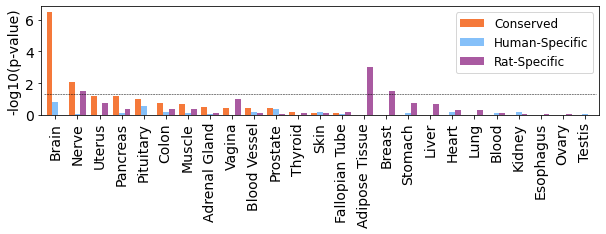

In [83]:
results.columns = ["Conserved", "Human-Specific", "Rat-Specific"]
fig, ax = plt.subplots(figsize=(10,2))
results.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#85c0f9", "#a95aa1"], fontsize=14)
ax.set_ylabel("-log10(p-value)", fontsize=14)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12)
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/triple_tissue_enrich.png", bbox_inches="tight", dpi=400)